# Final Report: CO2 Emissions and Temperature Rise: A Global and Regional Analysis

## Introduction
The relationship between CO2 emissions and global temperature rise is a crucial area of study in understanding climate change. This report investigates the correlation between CO2 emissions and temperature rise, focusing on both global and regional scales. By analyzing historical data, this analysis aims to uncover patterns and insights that can inform climate policy and mitigation strategies.

## Used Data

### HadCRUT5 Temperature Anomaly Dataset
- **Description**: This dataset contains global land and temperature anomalies from 1850 to the present.
- **Data Structure**: Variables include time, latitude, longitude, and temperature anomalies (`tas_mean`).
- **Licensing**: Licensed under the Open Government License v3.0.

### Our World in Data CO2 Emissions Dataset
- **Description**: This dataset contains data on global CO2 and greenhouse gas emissions by country and region over time.
- **Data Structure**: Key columns include country, year, CO2 emissions, CO2 per capita, CO2 per GDP, and temperature change from CO2.
- **Licensing**: Licensed under the Creative Commons BY License.


## Analysis

### Data Preparation And Initial Inspection

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
co2_emission_df = pd.read_sql_table('co2_emissions', 'sqlite:///../data/co2_emission_dataset.sqlite')
temperature_df = pd.read_sql_table('temperature_anomalies', 'sqlite:///../data/temperature_dataset.sqlite')

In [4]:
temperature_df["year"] = temperature_df["time"].dt.year
co2_emission_df = co2_emission_df[co2_emission_df["year"] >= 1950]
temperature_df = temperature_df[temperature_df["year"] >= 1950]

In [139]:
display(co2_emission_df.head())

,country,year,co2,co2_per_capita,co2_per_gdp,temperature_change_from_co2
100,Afghanistan,1950,0.084,0.011,0.009,0.0
101,Afghanistan,1951,0.092,0.012,0.009,0.0
102,Afghanistan,1952,0.092,0.012,0.009,0.0
103,Afghanistan,1953,0.106,0.014,0.010,0.0
104,Afghanistan,1954,0.106,0.014,0.010,0.0


In [140]:
display(temperature_df.head())

,time,latitude,longitude,temperature_anomaly,year
3110400,1950-01-16 12:00:00,-87.5,-177.5,NaN,1950
3110401,1950-01-16 12:00:00,-87.5,-172.5,NaN,1950
3110402,1950-01-16 12:00:00,-87.5,-167.5,NaN,1950
3110403,1950-01-16 12:00:00,-87.5,-162.5,NaN,1950
3110404,1950-01-16 12:00:00,-87.5,-157.5,NaN,1950


### Results

#### Global Analysis
World and Continents

In [109]:
continents = ["World", "North America", "South America", "Europe", "Africa", "Asia"]
continent_ranges = {
    "North America": ((7, 84), (-168, -52)),
    "South America": ((-56, 13), (-81, -34)),
    "Europe": ((34, 72), (-25, 45)),
    "Africa": ((-35, 38), (-18, 52)),
    "Asia": ((1, 77), (26, 180))
}

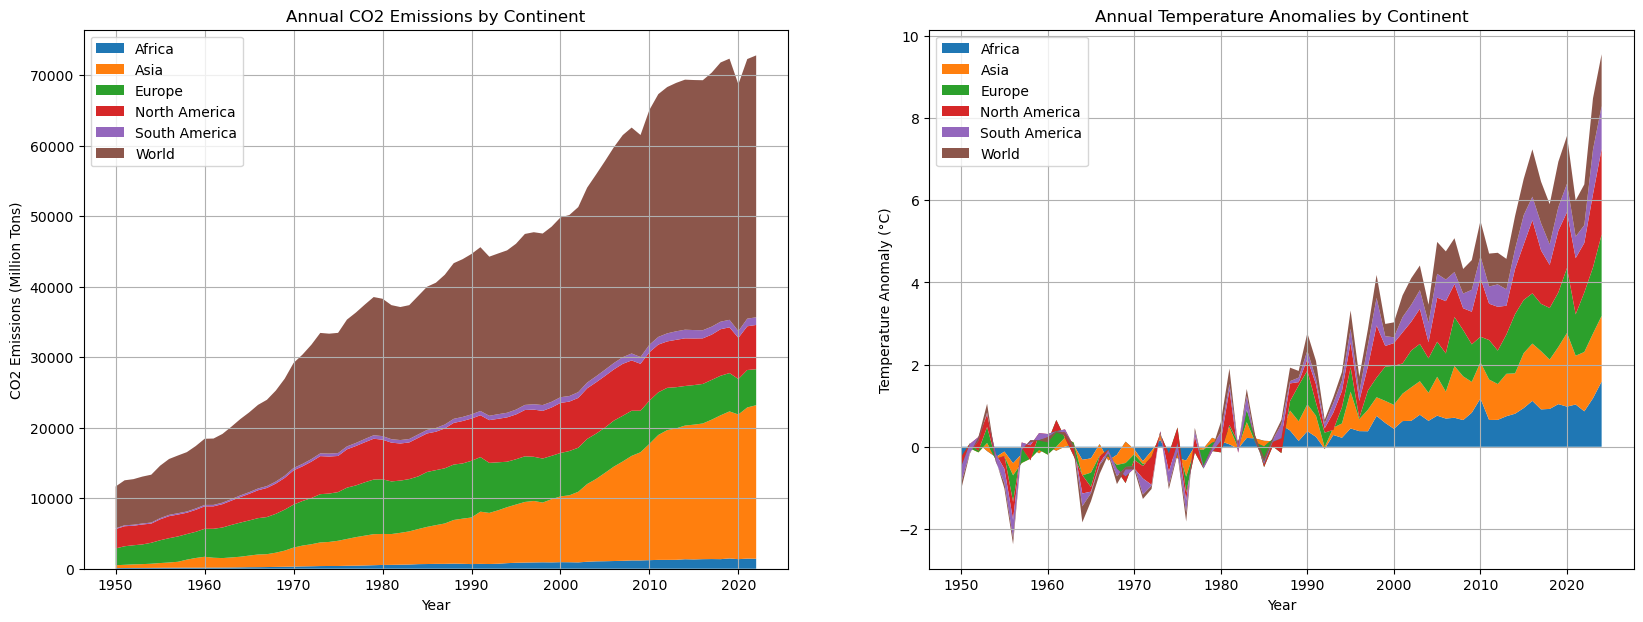

In [115]:
temperature_anomalies_continents = []
for continent, (lat_range, lon_range) in continent_ranges.items():
    continent_temp_data = temperature_df[(temperature_df["latitude"].between(*lat_range)) &
                                         (temperature_df["longitude"].between(*lon_range))]
    continent_temp_data = continent_temp_data.groupby("year")["temperature_anomaly"].mean().reset_index()
    continent_temp_data["continent"] = continent
    temperature_anomalies_continents.append(continent_temp_data)

world_temp_data = temperature_df.groupby("year")["temperature_anomaly"].mean().reset_index()
world_temp_data["continent"] = "World"
temperature_anomalies_continents.append(world_temp_data)

temperature_anomalies_continents = pd.concat(temperature_anomalies_continents)
temperature_by_continent = temperature_anomalies_continents.pivot(index="year", columns="continent", values="temperature_anomaly")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

co2_emissions_continents = co2_emission_df[co2_emission_df["country"].isin(continents)]
co2_by_continents = co2_emissions_continents.groupby(["year", "country"])["co2"].sum().unstack()
ax1.stackplot(co2_by_continents.index, co2_by_continents.T, labels=co2_by_continents.columns)
ax1.set_title("Annual CO2 Emissions by Continent")
ax1.set_xlabel("Year")
ax1.set_ylabel("CO2 Emissions (Million Tons)")
ax1.legend(loc="upper left")
ax1.grid(True)

ax2.stackplot(temperature_by_continent.index, temperature_by_continent.T, labels=temperature_by_continent.columns)
ax2.set_title("Annual Temperature Anomalies by Continent")
ax2.set_xlabel("Year")
ax2.set_ylabel("Temperature Anomaly (°C)")
ax2.legend(loc="upper left")
ax2.grid(True)

plt.show()

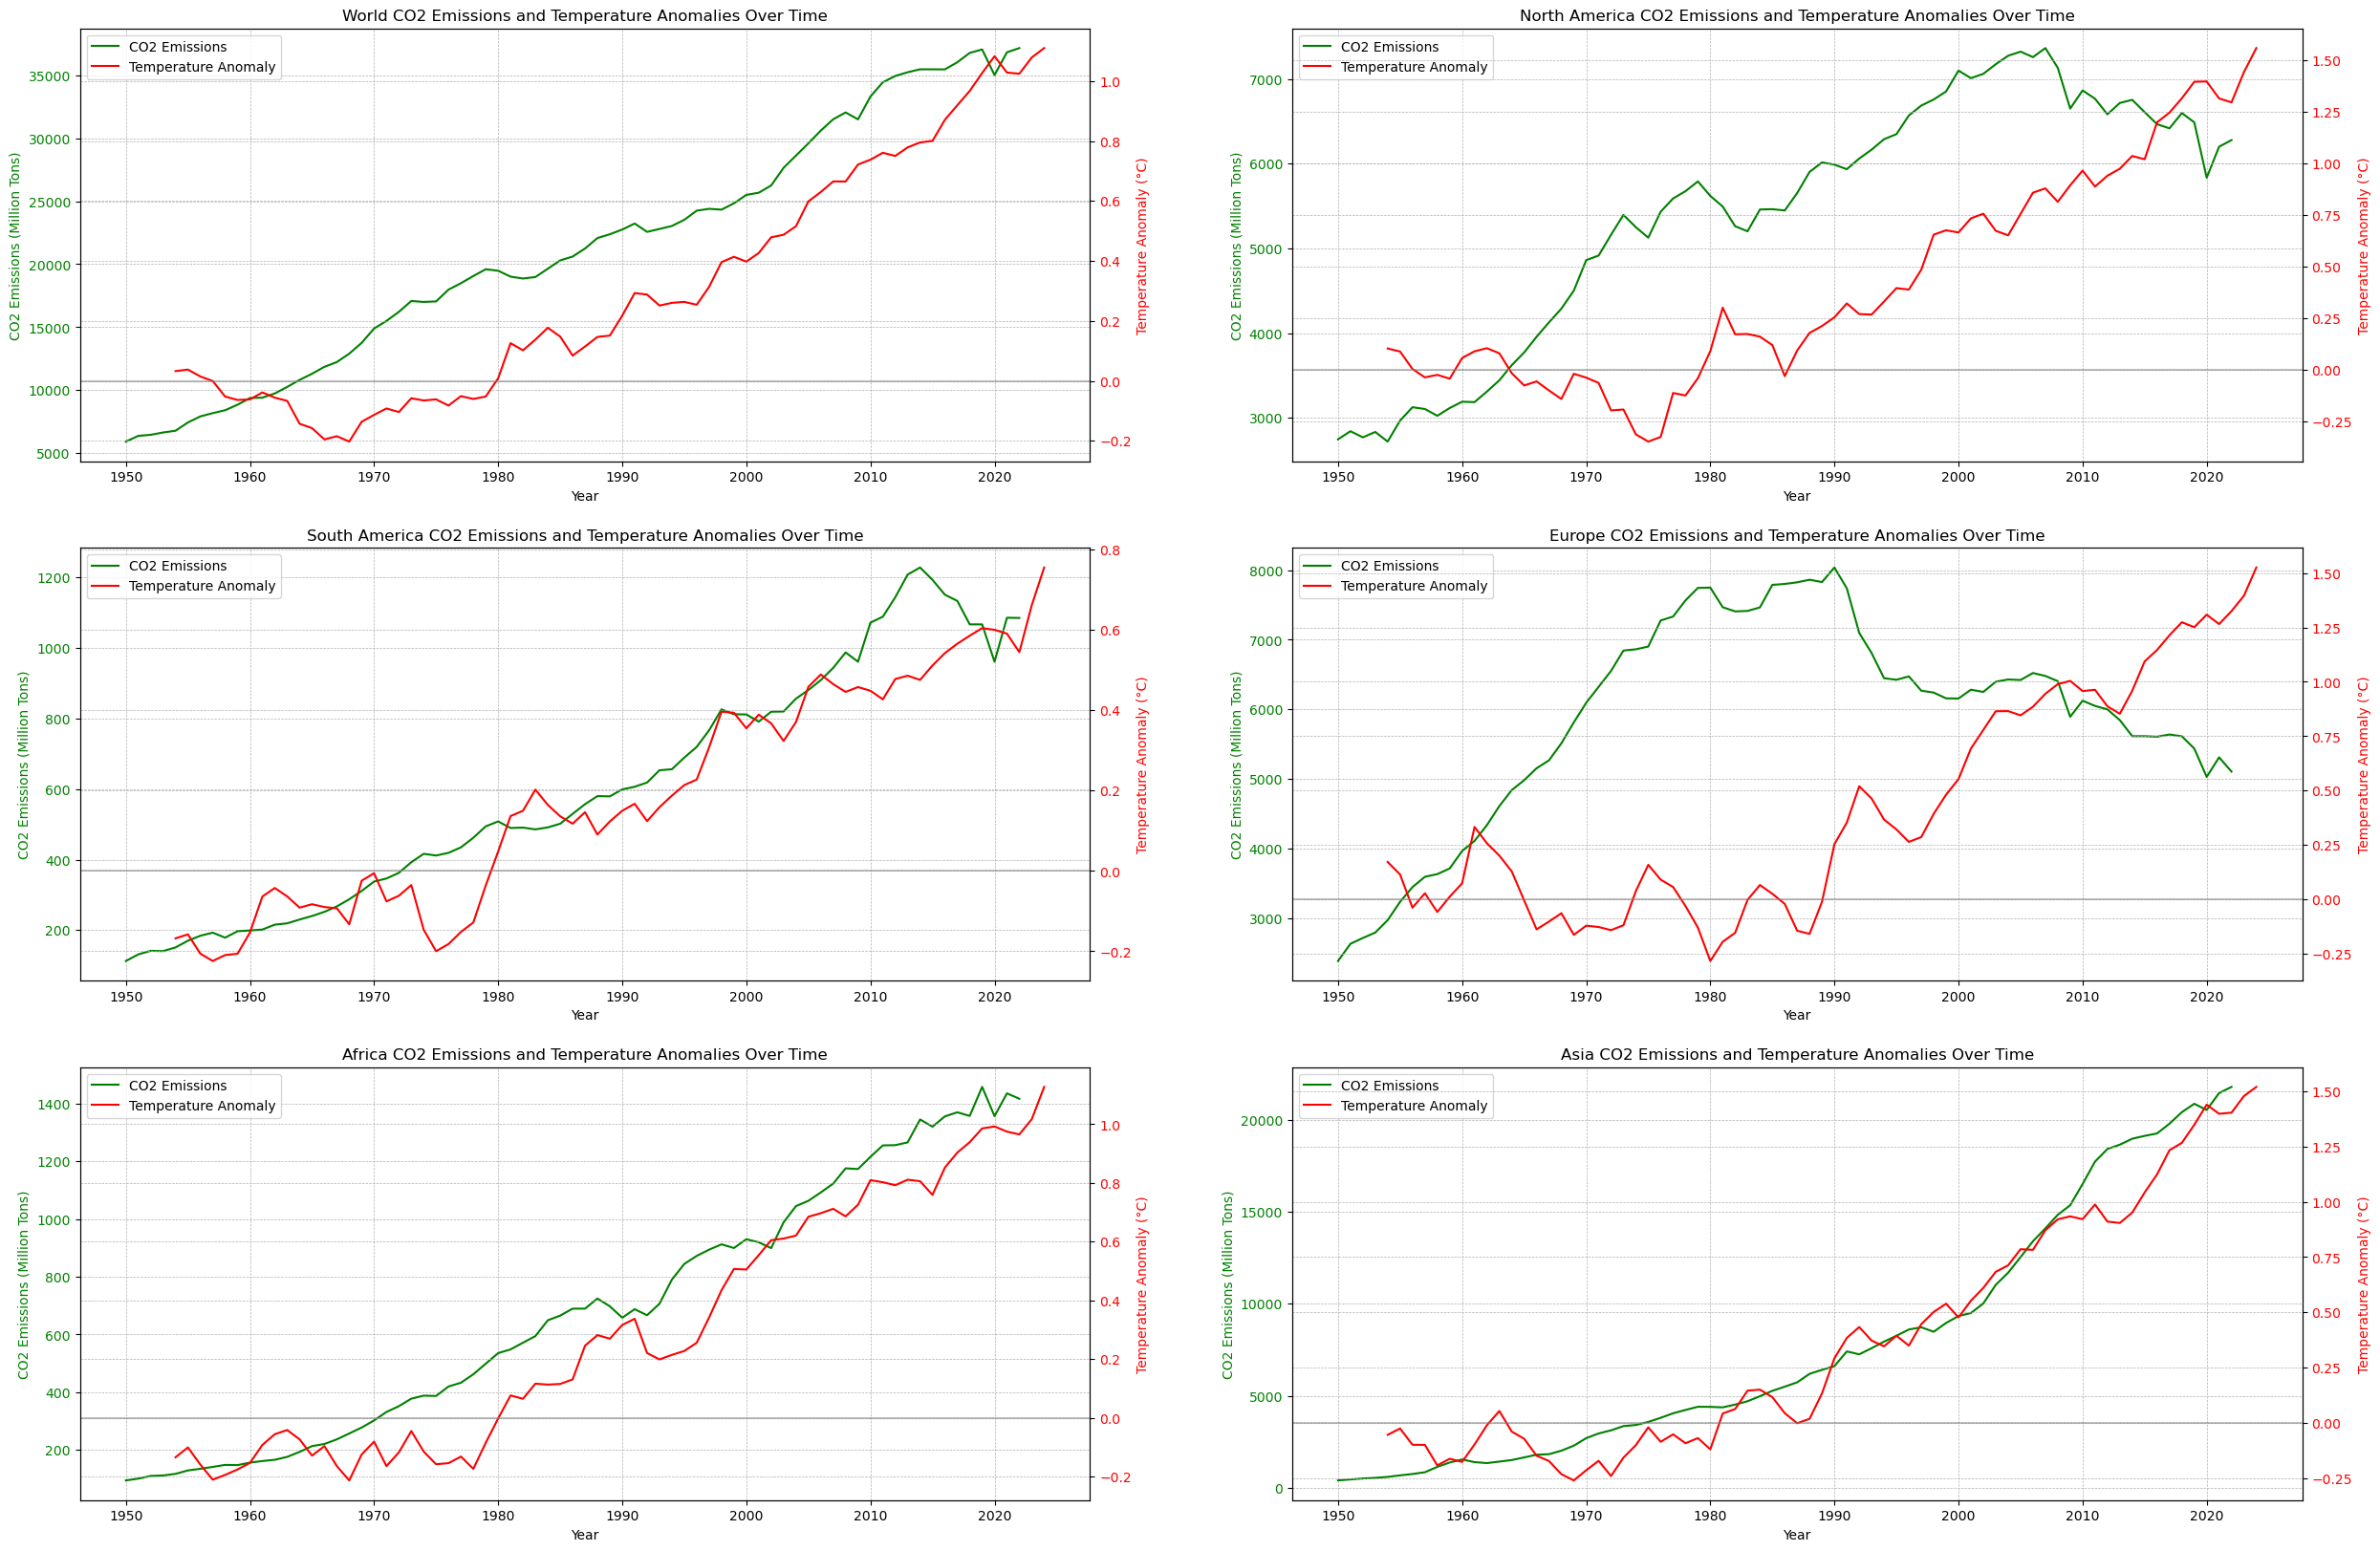

In [88]:
fig, axes = plt.subplots(3, 2, figsize=(30, 20))
for i, continent in enumerate(continents):
    if continent == "World":
        co2_emission_continent = co2_emission_df[co2_emission_df["country"] == "World"]
        continent_temperature = temperature_df.groupby("year")["temperature_anomaly"].mean().reset_index()
    else:
        co2_emission_continent = co2_emission_df[co2_emission_df["country"] == continent]

        latitude, longitude = continent_ranges[continent]
        continent_temperature = temperature_df[(temperature_df["latitude"].between(*latitude)) &
                                               (temperature_df["longitude"].between(*longitude))]
        continent_temperature = continent_temperature.groupby("year")["temperature_anomaly"].mean().reset_index()

    ax1 = axes[i // 2, i % 2]
    ax2 = ax1.twinx()

    ax1.plot(co2_emission_continent["year"], co2_emission_continent["co2"], color="green", label="CO2 Emissions")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("CO2 Emissions (Million Tons)", color="green")
    ax1.tick_params(axis="y", labelcolor="green")
    ax1.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax1.set_title(f"{continent} CO2 Emissions and Temperature Anomalies Over Time")

    ax2.plot(continent_temperature["year"], continent_temperature["temperature_anomaly"].rolling(window=5).mean(), color="red", label="Temperature Anomaly")
    ax2.set_ylabel("Temperature Anomaly (°C)", color="red")
    ax2.tick_params(axis="y", labelcolor="red")
    ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.axhline(y=0, color="grey", alpha=0.5)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.show()

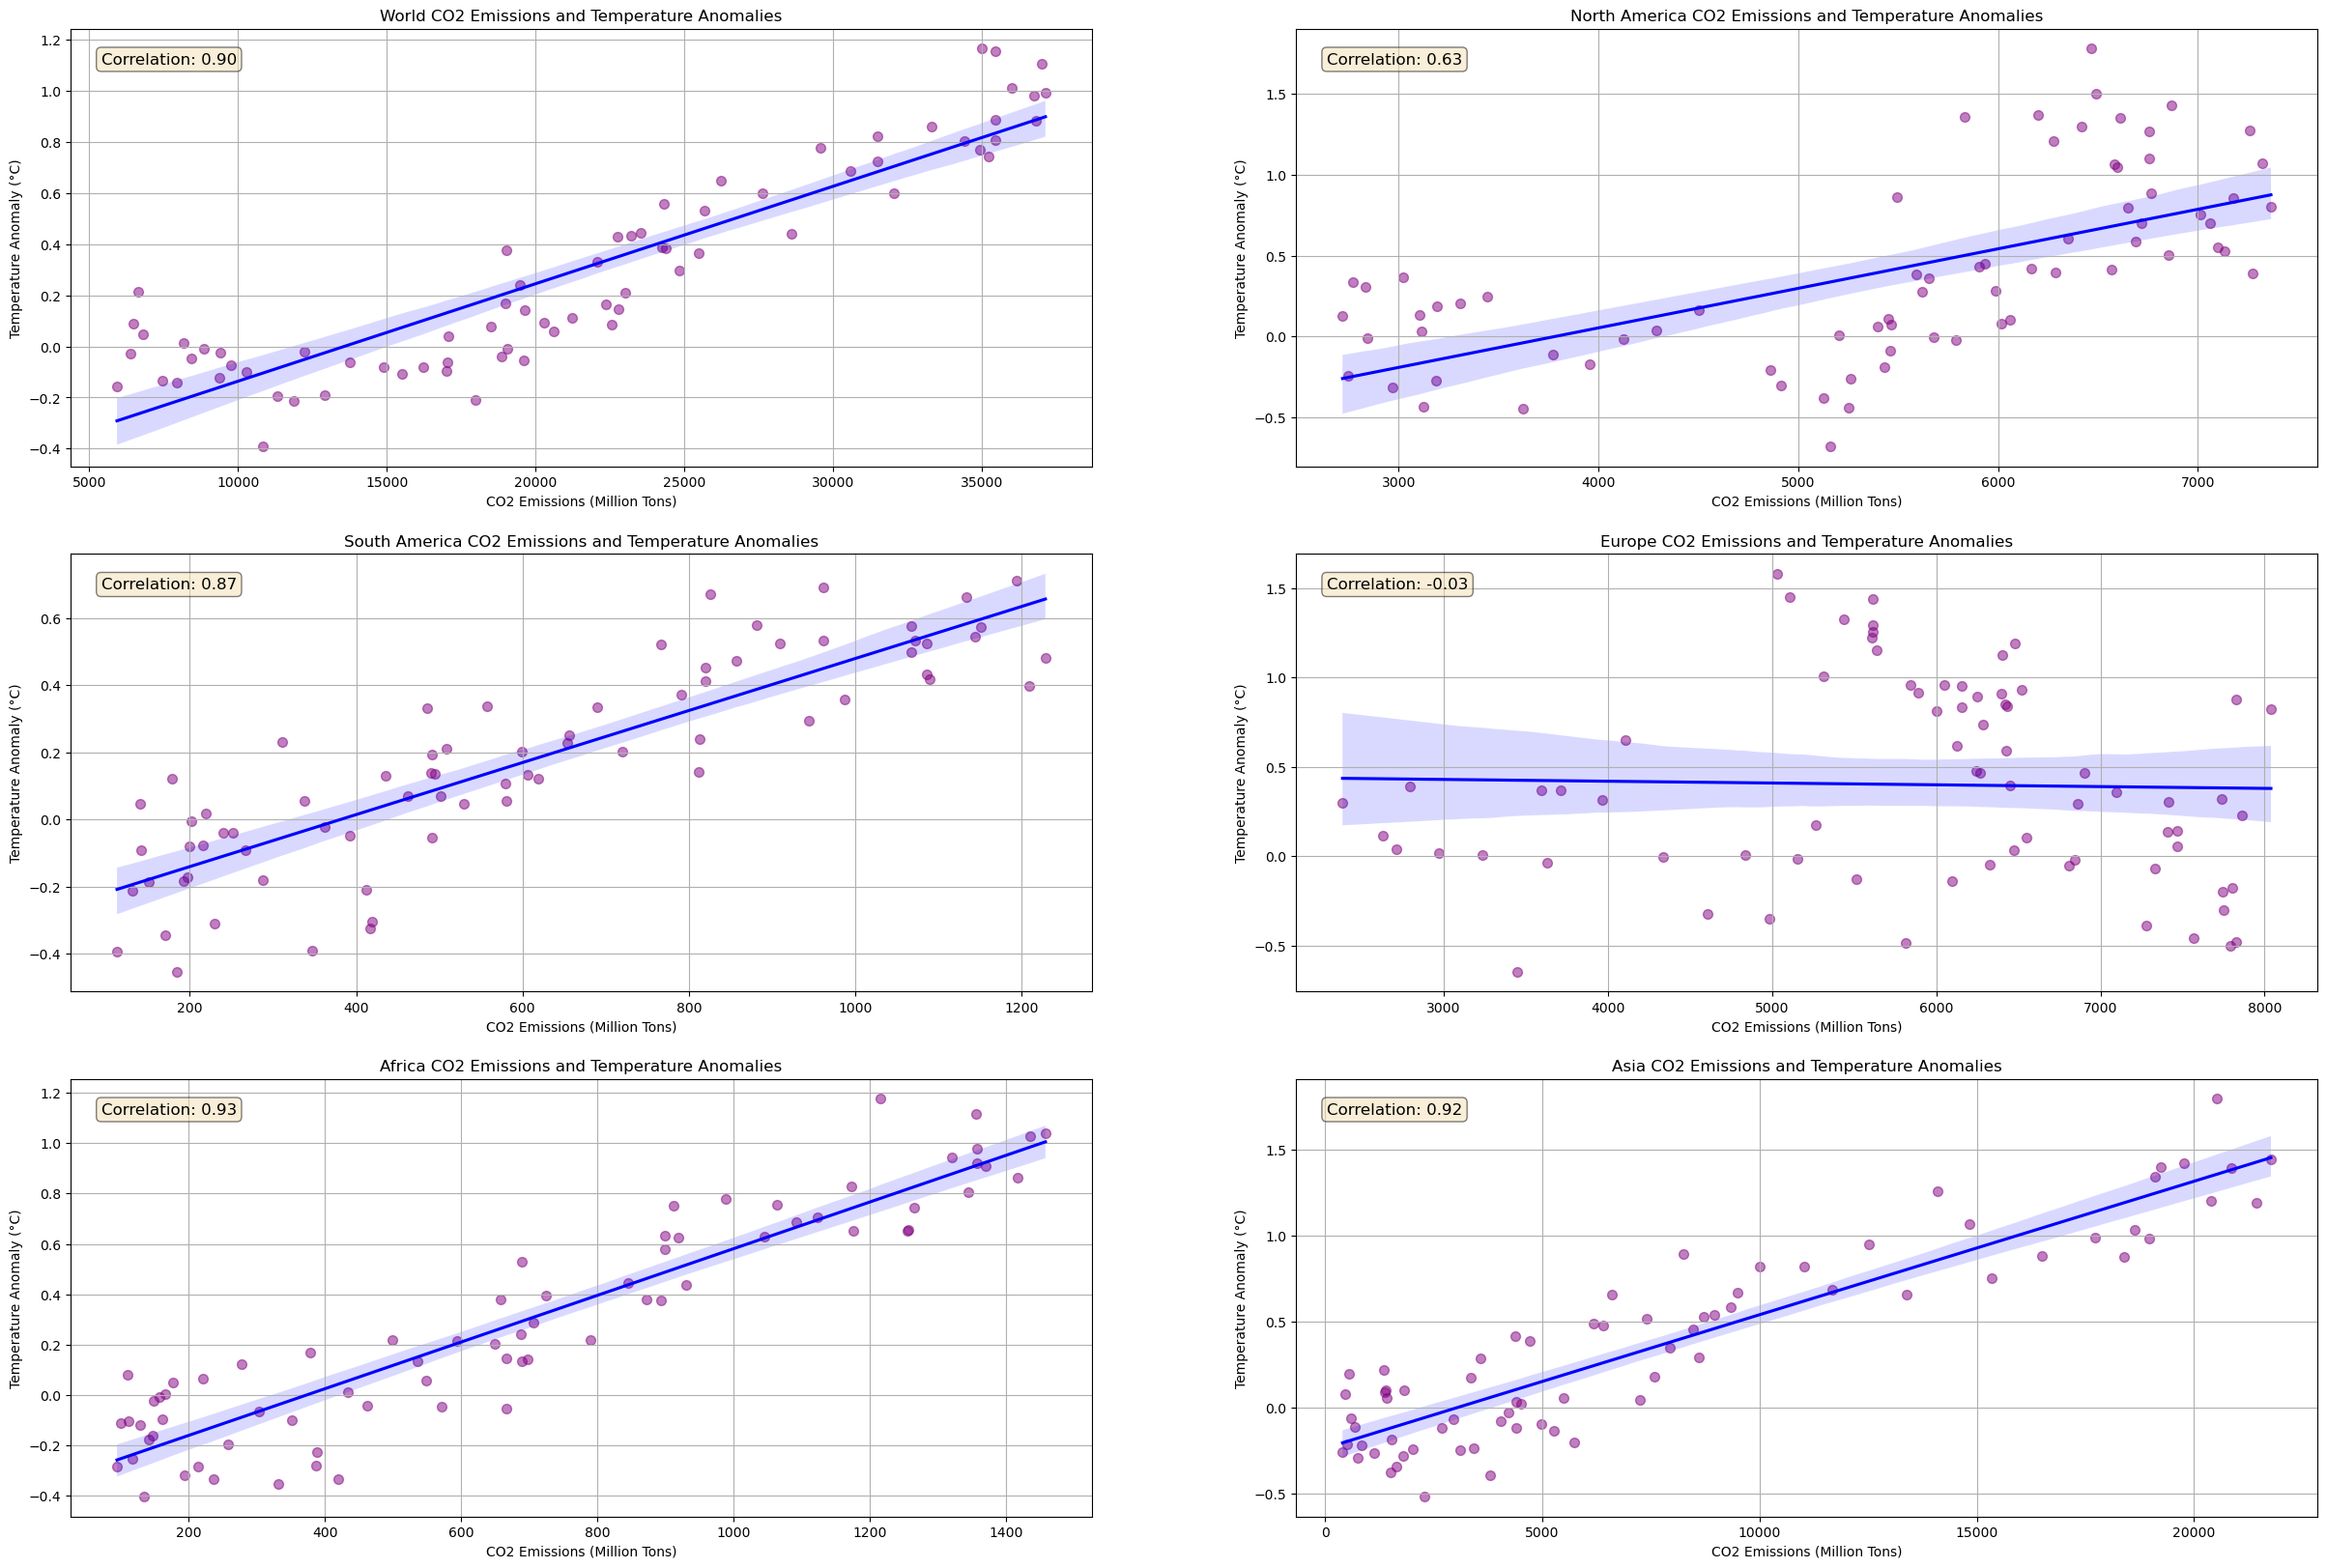

In [75]:
fig, axes = plt.subplots(3, 2, figsize=(30, 20))
for i, continent in enumerate(continents):
    if continent == "World":
        co2_emission_continent = co2_emission_df[co2_emission_df["country"] == "World"]
        continent_temperature = temperature_df.groupby("year")["temperature_anomaly"].mean().reset_index()
    else:
        co2_emission_continent = co2_emission_df[co2_emission_df["country"] == continent]

        latitude, longitude = continent_ranges[continent]
        continent_temperature = temperature_df[(temperature_df["latitude"].between(*latitude)) &
                                               (temperature_df["longitude"].between(*longitude))]
        continent_temperature = continent_temperature.groupby("year")["temperature_anomaly"].mean().reset_index()

    ax = axes[i // 2, i % 2]

    continent_co2_and_temperature = pd.merge(co2_emission_continent, continent_temperature, on="year")
    continent_co2_temp_corr = continent_co2_and_temperature["co2"].corr(continent_co2_and_temperature["temperature_anomaly"])

    sns.regplot(x=continent_co2_and_temperature["co2"], y=continent_co2_and_temperature["temperature_anomaly"],
                ax=ax, scatter_kws={"s": 50, "alpha":0.5, "color":"purple"}, line_kws={"color":"blue"})

    ax.set_title(f"{continent} CO2 Emissions and Temperature Anomalies")
    ax.text(0.03, 0.92, f"Correlation: {continent_co2_temp_corr:.2f}", transform=ax.transAxes,
            fontsize=12, bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
    ax.set_xlabel("CO2 Emissions (Million Tons)")
    ax.set_ylabel("Temperature Anomaly (°C)")
    ax.grid(True)

plt.show()

#### Regional Analysis

For Germany, the US, China, and India

In [116]:
country_ranges = {
    "Germany": ((47, 55), (6, 15)),
    "United States": ((24, 49), (-125, -66)),
    "China": ((18, 54), (73, 135)),
    "India": ((8, 37), (68, 97))
}

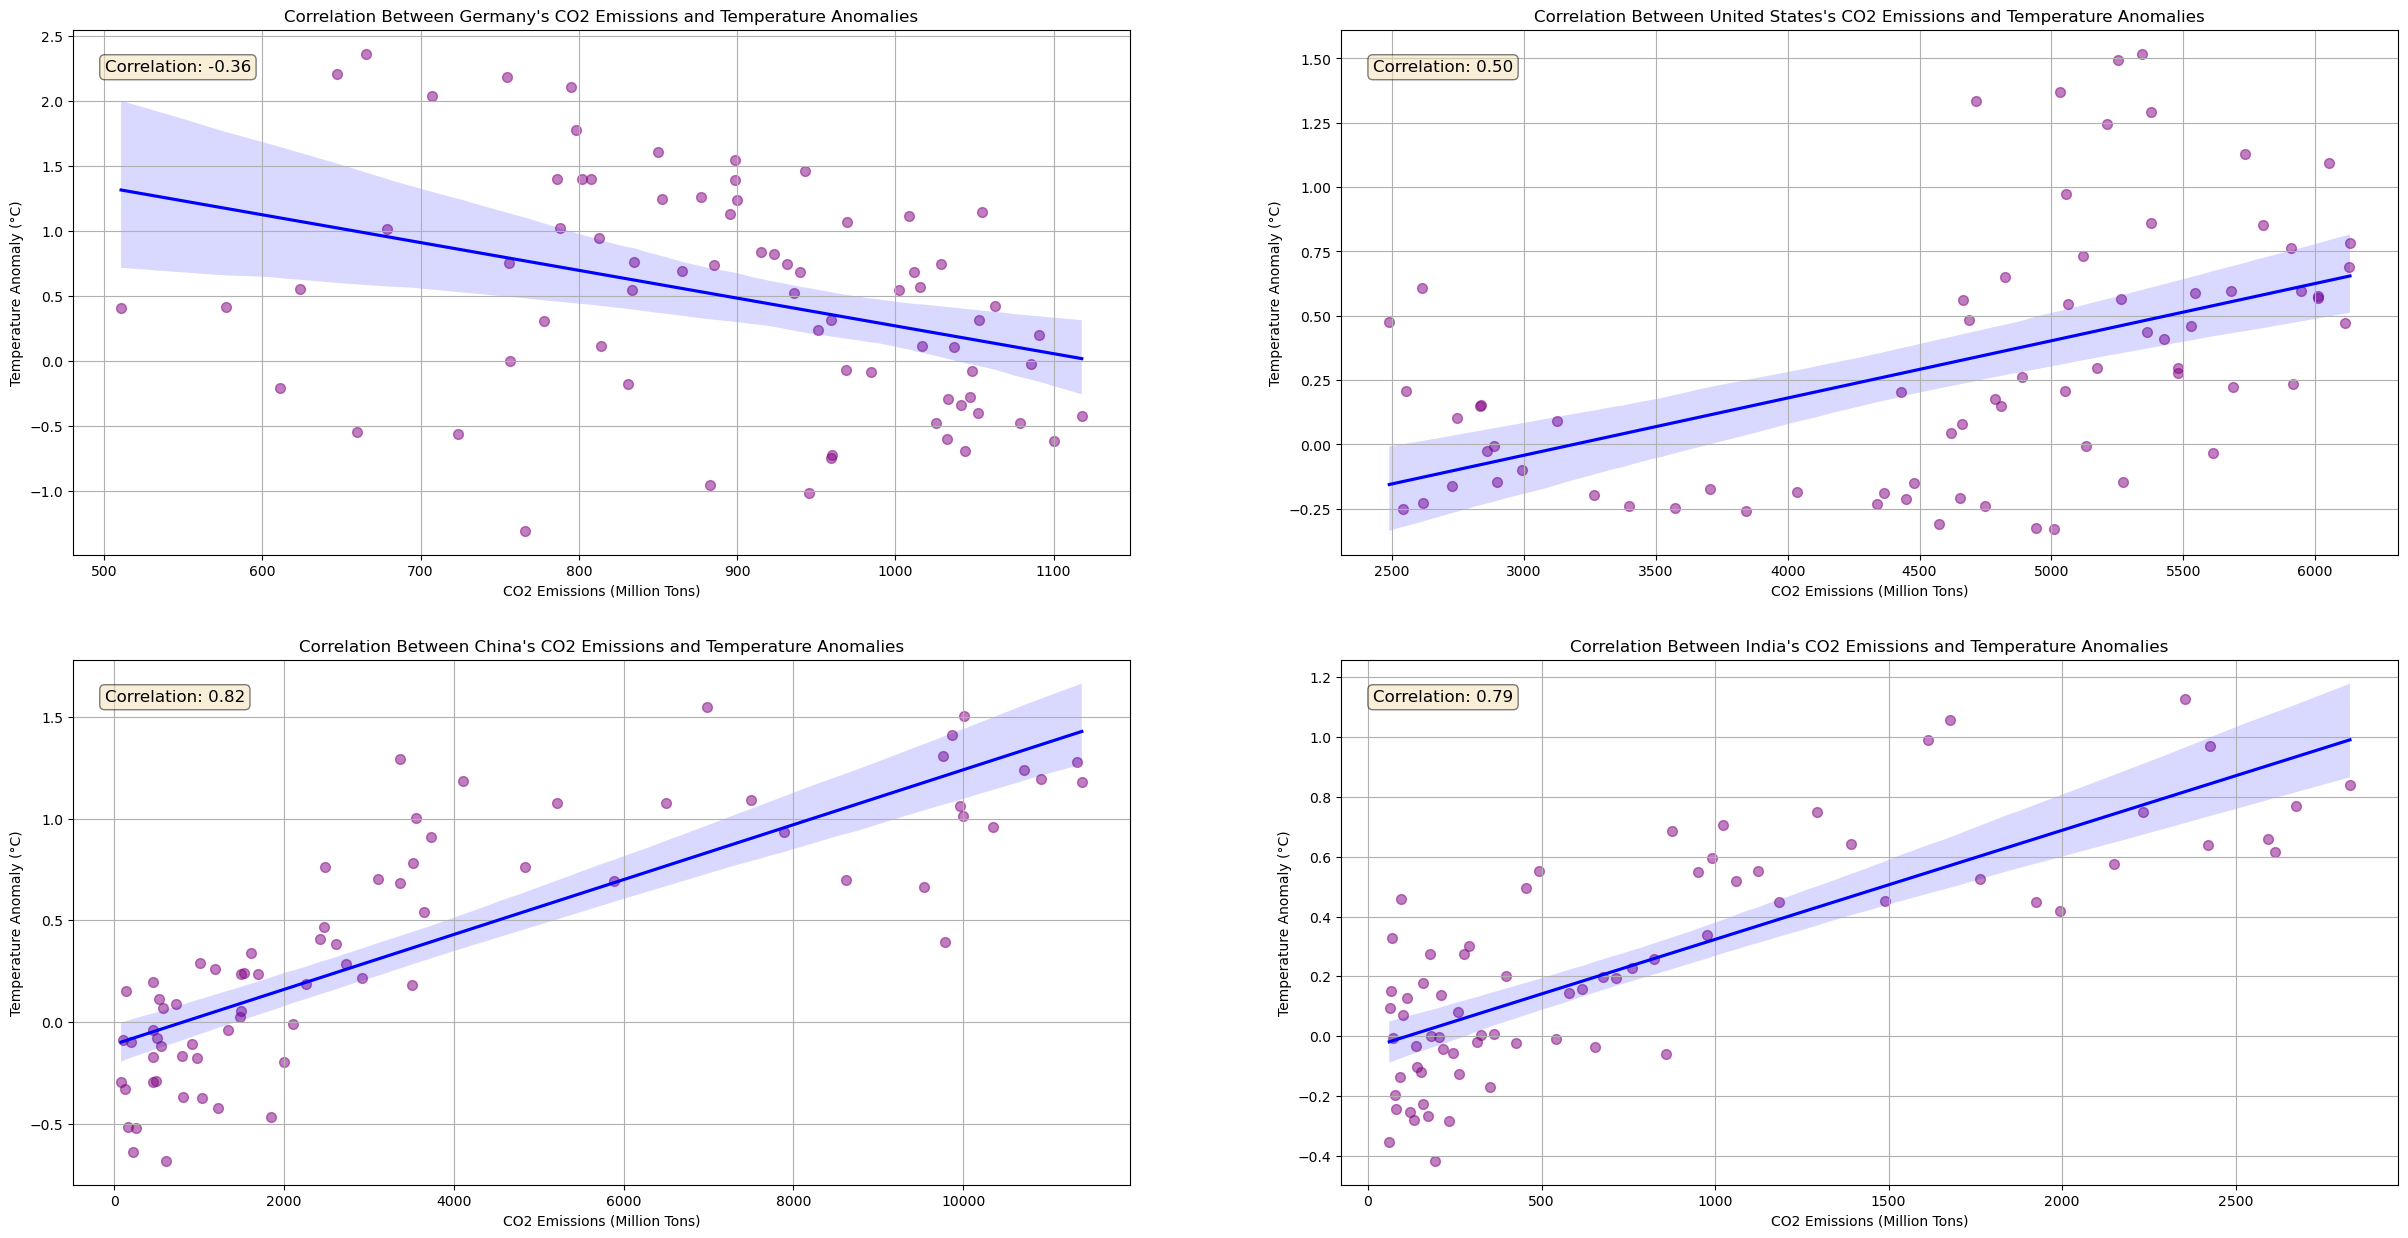

In [135]:
fig, axes = plt.subplots(2, 2, figsize=(30, 15))
for i, (country, (lat_range, lon_range)) in enumerate(country_ranges.items()):
    country_temperature = temperature_df[(temperature_df["latitude"].between(*lat_range)) &
                                         (temperature_df["longitude"].between(*lon_range))]
    country_temperature = country_temperature.groupby("year")["temperature_anomaly"].mean().reset_index()

    country_co2_emission = co2_emission_df[co2_emission_df["country"] == country]
    country_co2_and_temperature = pd.merge(country_co2_emission, country_temperature, on="year")
    country_co2_temp_corr = country_co2_and_temperature["co2"].corr(country_co2_and_temperature["temperature_anomaly"])

    ax = axes[i // 2, i % 2]

    sns.regplot(x=country_co2_and_temperature["co2"], y=country_co2_and_temperature["temperature_anomaly"],
                ax=ax, scatter_kws={"s": 50, "alpha":0.5, "color":"purple"}, line_kws={"color":"blue"})

    ax.set_title(f"Correlation Between {country}'s CO2 Emissions and Temperature Anomalies")
    ax.text(0.03, 0.92, f"Correlation: {country_co2_temp_corr:.2f}", transform=ax.transAxes,
            fontsize=12, bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
    ax.set_xlabel("CO2 Emissions (Million Tons)")
    ax.set_ylabel("Temperature Anomaly (°C)")
    ax.grid(True)

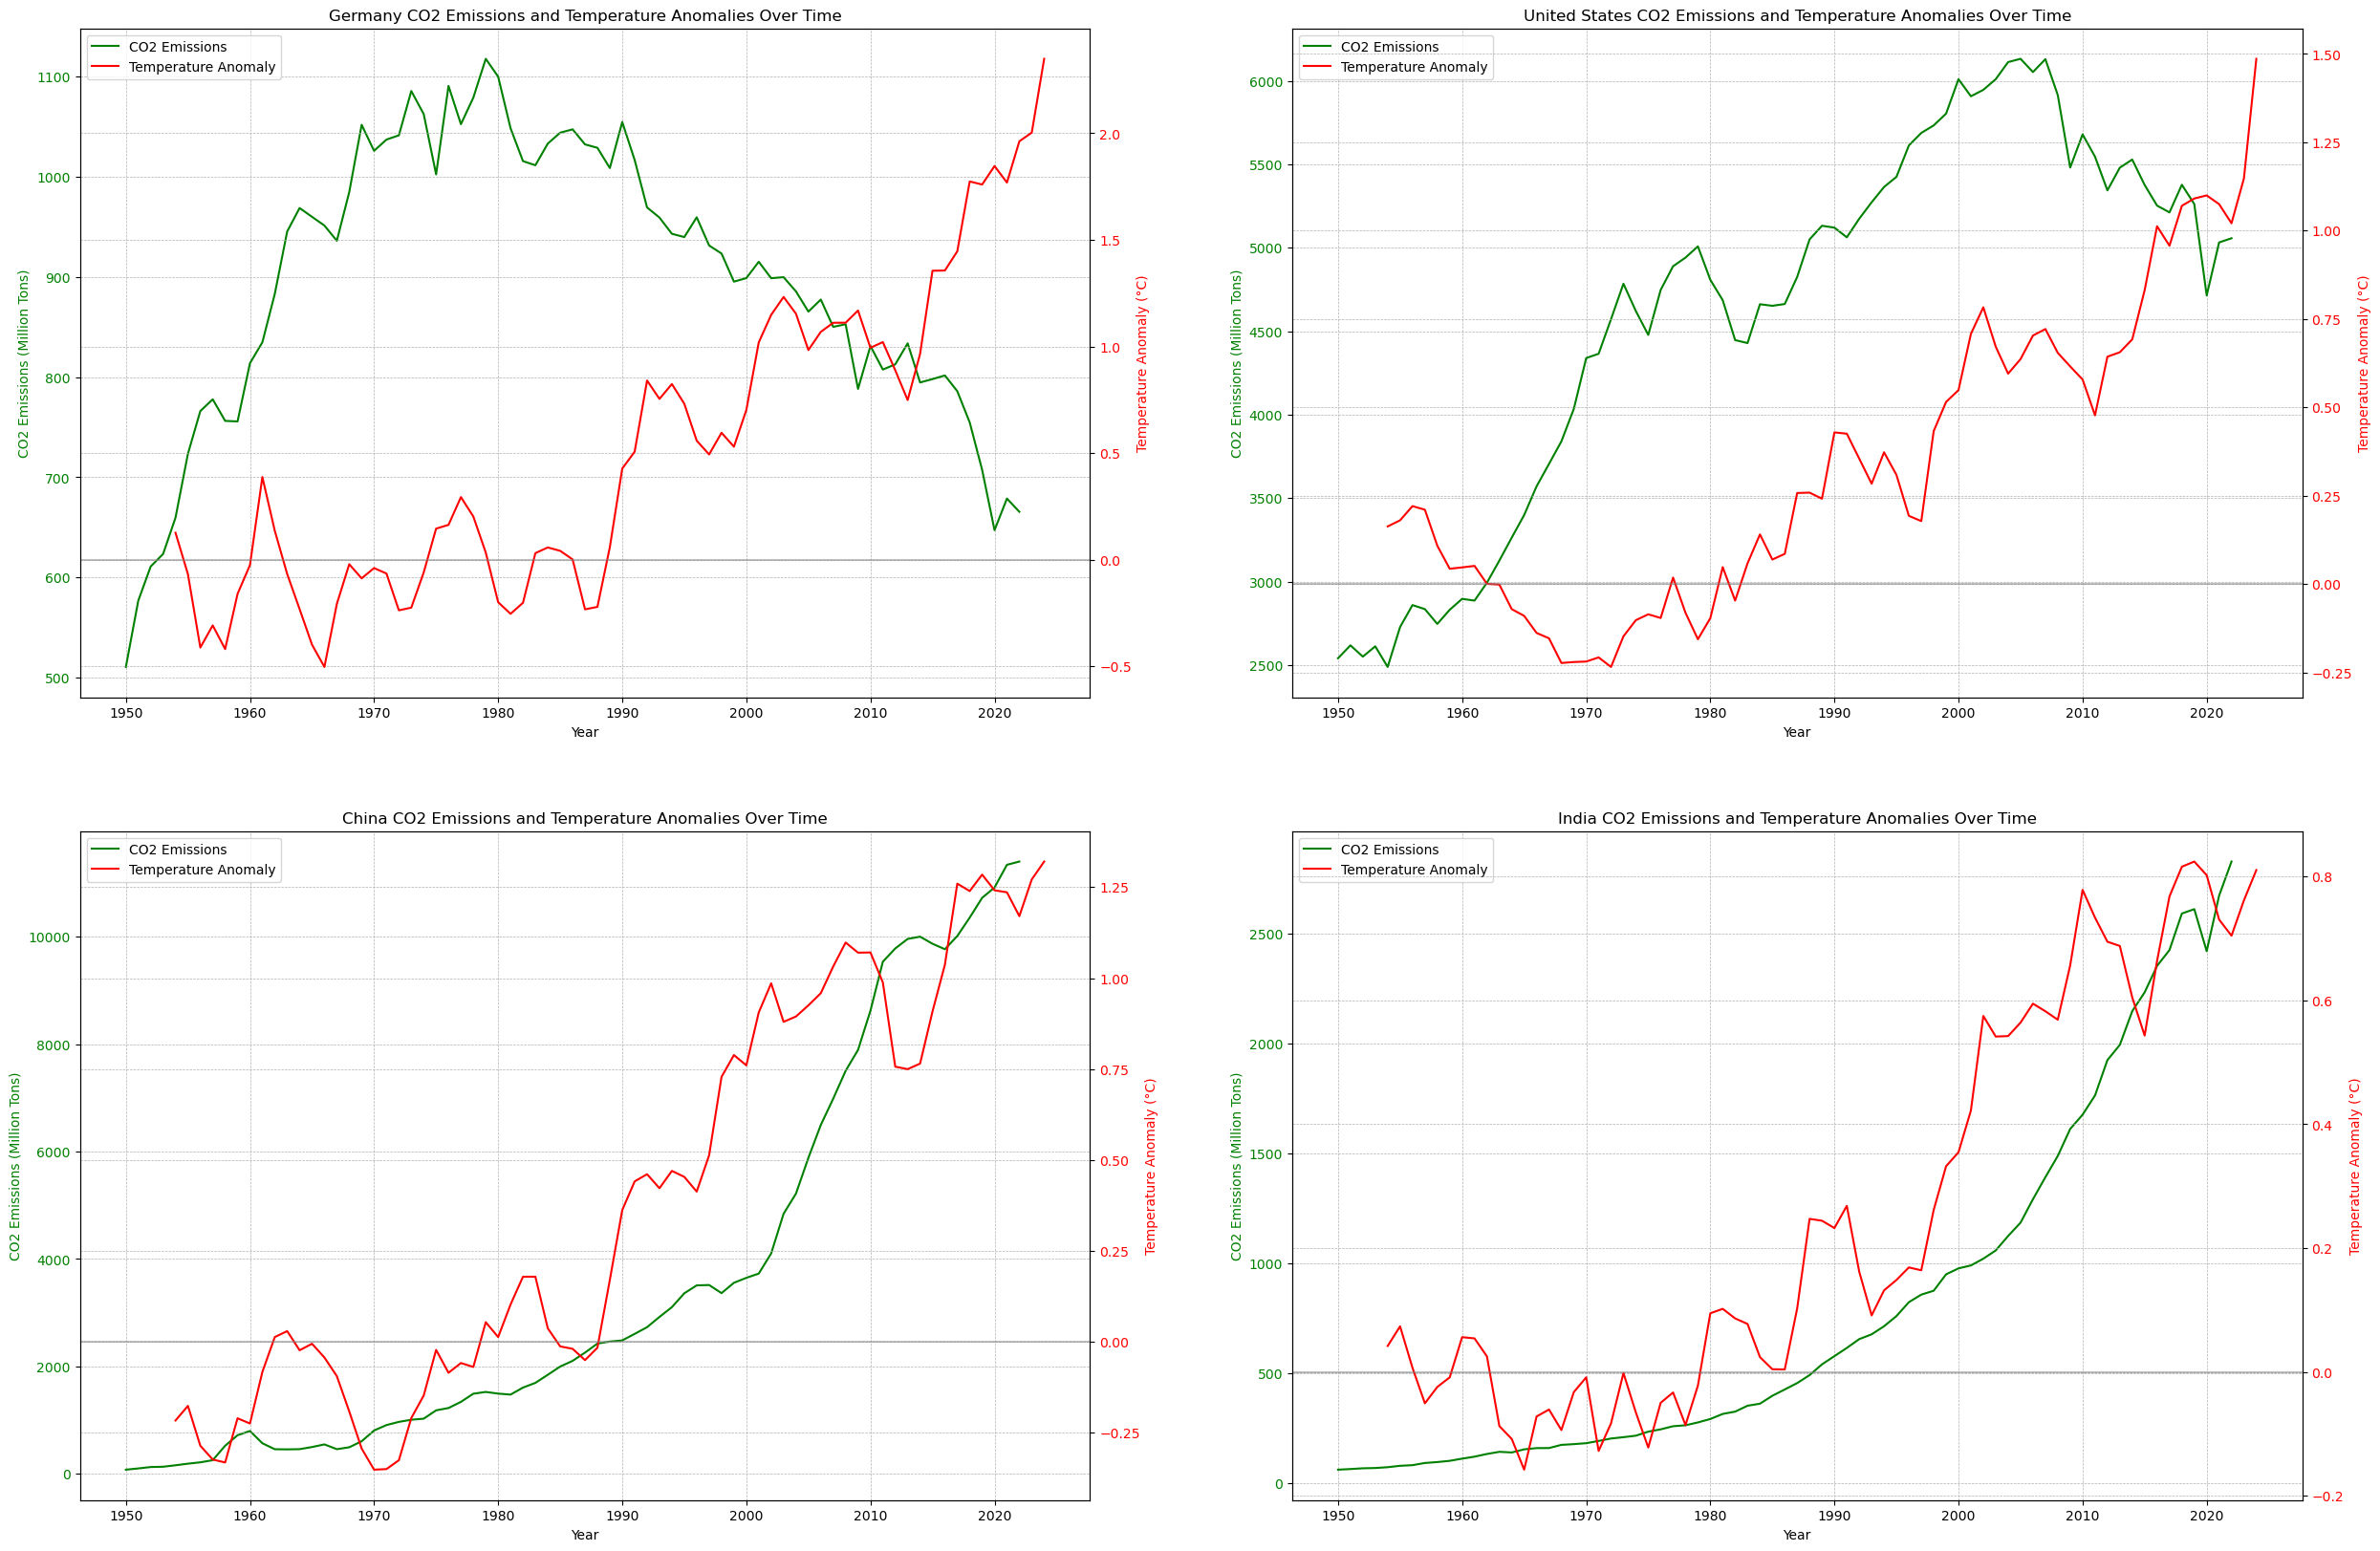

In [137]:
fig, axes = plt.subplots(2, 2, figsize=(30, 20))
for i, (country, (lat_range, lon_range)) in enumerate(country_ranges.items()):
    country_temperature = temperature_df[(temperature_df["latitude"].between(*lat_range)) &
                                         (temperature_df["longitude"].between(*lon_range))]
    country_temperature = country_temperature.groupby("year")["temperature_anomaly"].mean().reset_index()
    country_co2_emission = co2_emission_df[co2_emission_df["country"] == country]

    ax1 = axes[i // 2, i % 2]
    ax2 = ax1.twinx()

    ax1.plot(country_co2_emission["year"], country_co2_emission["co2"], color="green", label="CO2 Emissions")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("CO2 Emissions (Million Tons)", color="green")
    ax1.tick_params(axis="y", labelcolor="green")
    ax1.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax1.set_title(f"{country} CO2 Emissions and Temperature Anomalies Over Time")

    ax2.plot(country_temperature["year"], country_temperature["temperature_anomaly"].rolling(window=5).mean(), color="red", label="Temperature Anomaly")
    ax2.set_ylabel("Temperature Anomaly (°C)", color="red")
    ax2.tick_params(axis="y", labelcolor="red")
    ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.axhline(y=0, color="grey", alpha=0.5)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.show()